# Evaluation of CyteType

CyteType is a tool for automatic curation of cell types in single cell, using an LLM Annotator Agent.

In this notebook, I try the tool on a few datasets and compare it with other annotation tools.

### Install Libraries

In [ ]:
!python -m pip install -q cytetype scanpy

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\dallo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import anndata
import scanpy as sc
import cytetype
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Initialize Paul15 dataset

The Paul et al 2015 dataset is a small single-cell dataset of myeloid cells, available from scanpy. The Cell types have been manually annotated, meaning we can compare cytetype's predictions against the true values.

In [ ]:
#adata = sc.datasets.paul15()


  0%|          | 0.00/9.82M [00:00<?, ?B/s]

In [ ]:
import os
import scanpy as sc

if not os.path.exists("paul15_small.h5ad"):
    adata = sc.datasets.paul15()
    adata.write("paul15_small.h5ad")
else:
    adata = sc.read("paul15_small.h5ad")


### Process the data - compute clusters, etc

In [ ]:

# Load and preprocess your data
adata.var["gene_symbols"] = adata.var_names

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata) 
sc.tl.rank_genes_groups(adata, groupby='leiden', method='t-test')

# Initialize CyteType (performs data preparation)
annotator = cytetype.CyteType(adata, group_key='leiden')



In [25]:
# How many clusters are there?
print(f"Number of clusters: {len(adata.obs['leiden'].unique())}")
adata.obs['leiden'].value_counts().sort_index()


Number of clusters: 10


leiden
0    376
1    372
2    364
3    339
4    322
5    309
6    299
7    290
8     31
9     28
Name: count, dtype: int64

In [27]:
# Cluster annotation from original paper 
adata.obs["paul15_clusters"]


W31105      7MEP
W31106      15Mo
W31107      3Ery
W31108      15Mo
W31109      3Ery
           ...  
W39164      2Ery
W39165    13Baso
W39166      7MEP
W39167      15Mo
W39168      3Ery
Name: paul15_clusters, Length: 2730, dtype: category
Categories (19, object): ['1Ery', '2Ery', '3Ery', '4Ery', ..., '16Neu', '17Neu', '18Eos', '19Lymph']

### Call the Agent! Run the annotation

In [ ]:
# Run annotation
adata = annotator.run(
    study_context="Mouse bone marrow cells undergoing myeloid differentiation"
)

# View results
print(adata.obs.cytetype_leiden)

Waiting for results for job ID: 228e448a-f156-4eec-93ea-2abe231a3a26
View the automatically updating visualization report at: https://nygen-labs-prod--cell-annotation-agent-fastapi-app.modal.run/report/228e448a-f156-4eec-93ea-2abe231a3a26
250603:1856:11 |INFO| [STARTING WORKFLOWS]: Job ID: 228e448a-f156-4eec-93ea-2abe231a3a26
250603:1856:11 |INFO| [WORKFLOW STEP 1/3]: Generating context summary
250603:1856:29 |INFO| [WORKFLOW STEP 2/3]: Running cluster contextualization, annotation, review, and ontology assignment
250603:1856:31 |INFO| [Cluster: 1] Generating cluster-specific context...
250603:1856:33 |INFO| [Cluster: 10] Generating cluster-specific context...
250603:1856:34 |INFO| [Cluster: 2] Generating cluster-specific context...
250603:1856:36 |INFO| [Cluster: 3] Generating cluster-specific context...
250603:1856:38 |INFO| [Cluster: 4] Generating cluster-specific context...
250603:1856:48 |INFO| [Cluster: 2] Annotating cluster...
250603:1856:53 |INFO| [Cluster: 1] Annotating cluste

### Compare annotation with existing one

In [14]:
print(adata.obs.cytetype_leiden)

W31105                          
W31106                 Microglia
W31107    Erythroid lineage cell
W31108                Neutrophil
W31109    Erythroid lineage cell
                   ...          
W39164           Erythroid cells
W39165                Neutrophil
W39166                          
W39167                Neutrophil
W39168    Erythroid lineage cell
Name: cytetype_leiden, Length: 2730, dtype: category
Categories (8, object): ['', 'Erythrocyte', 'Erythroid cells', 'Erythroid lineage cell', 'Hematopoietic progenitor cell', 'Microglia', 'Natural killer cell', 'Neutrophil']


In [17]:
print(adata.obs.paul15_clusters)

W31105      7MEP
W31106      15Mo
W31107      3Ery
W31108      15Mo
W31109      3Ery
           ...  
W39164      2Ery
W39165    13Baso
W39166      7MEP
W39167      15Mo
W39168      3Ery
Name: paul15_clusters, Length: 2730, dtype: category
Categories (19, object): ['1Ery', '2Ery', '3Ery', '4Ery', ..., '16Neu', '17Neu', '18Eos', '19Lymph']


In [18]:
label_map = {
    '1Ery': 'Erythroid lineage cell',
    '2Ery': 'Erythroid lineage cell',
    '3Ery': 'Erythroid lineage cell',
    '4Ery': 'Erythroid lineage cell',
    '5MEP': 'Hematopoietic progenitor cell',
    '6MEP': 'Hematopoietic progenitor cell',
    '7MEP': 'Hematopoietic progenitor cell',
    '8GMP': 'Hematopoietic progenitor cell',
    '9DC': 'Hematopoietic progenitor cell',
    '10Baso': 'Hematopoietic progenitor cell',
    '11Mo': 'Hematopoietic progenitor cell',
    '12Mo': 'Hematopoietic progenitor cell',
    '13Baso': 'Hematopoietic progenitor cell',
    '14Mo': 'Hematopoietic progenitor cell',
    '15Mo': 'Hematopoietic progenitor cell',
    '16Neu': 'Neutrophil',
    '17Neu': 'Neutrophil',
    '18Eos': 'Hematopoietic progenitor cell',
    '19Lymph': 'Natural killer cell'  # could be NK/T-cell; best-effort match
}


In [21]:
adata.obs["true_broad"] = adata.obs["paul15_clusters"].map(label_map)

pd.crosstab(adata.obs["true_broad"], adata.obs["cytetype_leiden"], normalize='index')


cytetype_leiden,,Erythrocyte,Erythroid cells,Erythroid lineage cell,Hematopoietic progenitor cell,Microglia,Natural killer cell,Neutrophil
true_broad,,,,,,,,
Erythroid lineage cell,0.017520,0.082210,0.45283,0.447439,0.000000,0.000000,0.000000,0.000000
Hematopoietic progenitor cell,0.159420,0.004831,0.00000,0.000000,0.088889,0.287923,0.000000,0.458937
Natural killer cell,0.032258,0.000000,0.00000,0.000000,0.000000,0.000000,0.967742,0.000000
Neutrophil,0.048387,0.000000,0.00000,0.000000,0.069892,0.059140,0.000000,0.822581


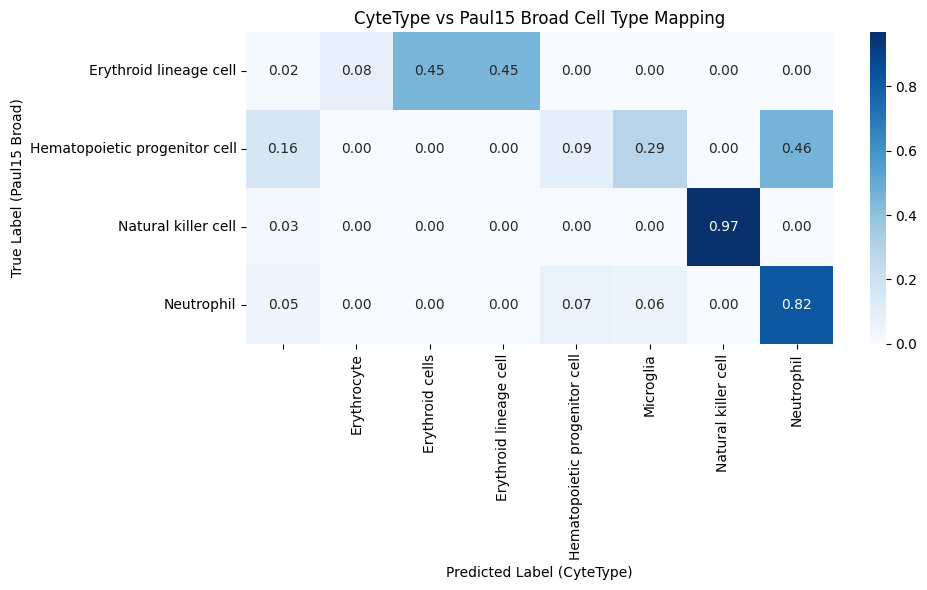

In [30]:
# Create normalized confusion matrix
conf_mat = pd.crosstab(
    adata.obs["true_broad"], 
    adata.obs["cytetype_leiden"], 
    normalize='index'
)

# Plot with seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt=".2f", cbar=True)
plt.title("CyteType vs Paul15 Broad Cell Type Mapping")
plt.ylabel("True Label (Paul15 Broad)")
plt.xlabel("Predicted Label (CyteType)")
plt.tight_layout()
plt.show()